In [12]:
import librosa
import librosa.feature
import librosa.display

import matplotlib.pyplot as plt

import numpy as np
from scipy import signal
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import sklearn

import torch
import torchaudio

import pandas as pd
import os
import re

from FSDDComparisonHelp import FSDD, getMFCC, getTwoMFCCs, showMFCC, compareFeatures

# plt.style.use("classic")
# plt.style.use("bmh")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True

In [118]:
def getTrainSet(speakerFilesList : list):
	trainList = []
	for file in speakerFilesList:
		y, sr = librosa.load(file)
		# S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, fmax=8000)
		S = librosa.feature.mfcc(y=y, sr=sr, dct_type=1)
		trainList.append(S)
	# trim
	minLen = min(el.shape[1] for el in trainList)
	trainList = [el[:, :minLen] for el in trainList]
	# stack
	train = np.stack(trainList)
	# reshape to 2d
	nSamples, nx, ny = train.shape
	twoDimTrain = train.reshape((nSamples, nx*ny))
	print(f'nx = {nx}, ny = {ny}')
	return twoDimTrain, nx, ny


def getTestSet(speakerFilesList : list, maxLen : int):
	trainList = []
	for file in speakerFilesList:
		y, sr = librosa.load(file)
		# S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, fmax=8000)
		S = librosa.feature.mfcc(y=y, sr=sr, dct_type=1)
		trainList.append(S)
	# trim
	minLen = min(el.shape[1] for el in trainList)
	trainList = [el[:, :min(maxLen, minLen)] for el in trainList]
	# shapes = {arr.shape for arr in trainList}
	# print(shapes)
	# stack
	train = np.stack(trainList)
	# reshape to 2d
	nSamples, nx, ny = train.shape
	twoDimTrain = train.reshape((nSamples, nx*ny))
	print(f'nx = {nx}, ny = {ny}')
	return twoDimTrain


def getFeatureList(speakerFilesList : list):
	featureList = []
	for file in speakerFilesList:
		y, sr = librosa.load(file)
		# S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, fmax=8000)
		S = librosa.feature.mfcc(y=y, sr=sr, dct_type=3)
		featureList.append(S)
	return featureList

def trimFeatures(collection : list):
	newCollection = []
	minLen = min(min([feature.shape[1] for feature in featureList]) for featureList in collection)
	for featureList in collection:
		newFeatureList = [feature[:, :minLen] for feature in featureList]
		newCollection.append(newFeatureList)
	return newCollection

def getLinearFeatureList(featureList : list):
	res = np.stack(featureList)
	# reshape to 2d
	nSamples, nx, ny = res.shape
	twoDimRes = res.reshape((nSamples, nx*ny))
	return twoDimRes, nx, ny

# def trim(collection):
# 	minLen = min(el.shape[1] for el in collection)
# 	collection = [el[:, :minLen] for el in collection]

In [42]:
fsdd = FSDD('../Datasets/FSDD/recordings')
filesA, filesB = fsdd.getFilesForDigit(0, spkA=1, spkB=3)

In [ ]:
# fA0, sr = librosa.load(filesA[0])
# S = librosa.feature.mfcc(y=fA0, sr=sr, n_mels=128, n_fft=512, dct_type=2)
# librosa.display.specshow(S, sr=sr, x_axis='time', cmap = 'bwr')
# plt.show()

In [80]:
trainA, nx, ny = getTrainSet(filesA)
trainB, nx, ny = getTrainSet(filesB)

gmA = GaussianMixture(n_components=1, random_state=0).fit(trainA)
gmB = GaussianMixture(n_components=1, random_state=0).fit(trainB)

nx = 20, ny = 13
nx = 20, ny = 12


In [ ]:
# если заюзать спектрограмму с вытащить mean:
# librosa.display.specshow(gmA.means_.reshape((80, 13)), sr=8000, x_axis='time', cmap = 'bwr')
# plt.show()

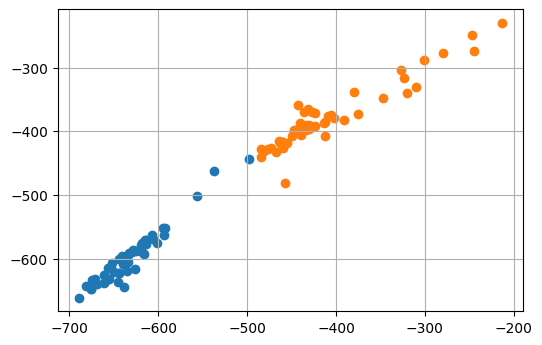

In [81]:
plt.scatter(x=trainA[:, 0], y=trainA[:, 1])
plt.scatter(x=trainB[:, 0], y=trainB[:, 1])
plt.show()

In [82]:
fsdd = FSDD('../Datasets/FSDD/recordings')
filesA, filesB = fsdd.getFilesForDigit(0, spkA=0, spkB=3)

train2, nx, ny = getTrainSet([*filesA, *filesB])

gm2 = GaussianMixture(n_components=2, random_state=0).fit(train2)

for i in range(len(filesA)):
	for j in range(len(filesB)):
		test2 = [train2[i], train2[-j-1]]
		a, b = gm2.predict(test2)
		if a == b:
			print(i, j)

nx = 20, ny = 12


In [147]:
fsdd = FSDD('../Datasets/FSDD/recordings')
print(fsdd.speakers)
filesA, filesB = fsdd.getFilesForDigit(0, spkA=1, spkB=5)

mfccsA = getFeatureList(filesA)
mfccsB = getFeatureList(filesB)
mfccsA, mfccsB = trimFeatures([mfccsA, mfccsB])
# shapesA = {a.shape for a in mfccsA}
# shapesB = {b.shape for b in mfccsB}
# print(shapesA)
# print(shapesB)

['jackson', 'theo', 'lucas', 'george', 'nicolas', 'yweweler']


In [148]:
# train test split
testsize = 47

train3, nx, ny = getLinearFeatureList([*mfccsA[:-testsize], *mfccsB[:-testsize]])
test3, nx, ny = getLinearFeatureList([*mfccsA[-testsize:], *mfccsB[-testsize:]])

gm3 = GaussianMixture(n_components=2, random_state=0).fit(train3)

Y = gm3.predict(test3)
print(Y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


In [149]:
# train test split
testsize = 5

train4A, nx, ny = getLinearFeatureList(mfccsA[:-testsize])
train4B, nx, ny = getLinearFeatureList(mfccsB[:-testsize])

test4A, nx, ny = getLinearFeatureList(mfccsA[-testsize:])
test4B, nx, ny = getLinearFeatureList(mfccsB[-testsize:])

gm4A = GaussianMixture(n_components=1, random_state=0).fit(train4A)
gm4B = GaussianMixture(n_components=1, random_state=0).fit(train4B)


In [150]:
maxDistSameA = max([np.mean((gm4A.means_ - ta)**2) for ta in test4A])
maxDistSameB = max([np.mean((gm4B.means_ - tb)**2) for tb in test4B])
print(f'Maximum distanse to center of valid:')
print(maxDistSameA)
print(maxDistSameB)

Maximum distanse to center of valid:
155.60019096108414
380.5230979975729


In [151]:
minDistSameA = min([np.mean((gm4A.means_ - tb)**2) for tb in test4B])
minDistSameB = min([np.mean((gm4B.means_ - ta)**2) for ta in test4A])
print(f'Minimum distanse to center of another:')
print(minDistSameA)
print(minDistSameB)

Minimum distanse to center of another:
706.7494855421098
472.4629428677702


In [152]:
gm4A.lower_bound_

1116.8912286577265

In [160]:
gm4A.score_samples(test4A)

array([-1.54386000e+09, -1.18956173e+09, -2.74009965e+09, -2.04204723e+09,
       -2.81302163e+09])

In [161]:
gm4A.score_samples(test4B)

array([-1.84888070e+10, -1.84787058e+10, -2.22527699e+10, -1.14087392e+10,
       -9.37602744e+09])